In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import mysql.connector
import matplotlib.pyplot as plt


Extract

In [2]:


CSV_PATH = "data/candidates.csv"   # ajusta si está en otra ruta

# 1) Leer CSV
df = pd.read_csv(CSV_PATH, sep=";")


# 2) Normalizar nombres de columnas -> snake_case
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 3) Limpieza básica de strings
for col in ["first_name","last_name","email","country","seniority","technology"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# 4) Parsear fecha de aplicación
df["application_date"] = pd.to_datetime(df["application_date"], errors="coerce")

# 5) Asegurar tipos numéricos
num_cols = ["yoe","code_challenge_score","technical_interview_score"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")




Transformation

In [3]:
# 6) Regla de negocio: HIRED si ambos scores >= 7
df["hired_flag"] = (
    (df["code_challenge_score"] >= 7) &
    (df["technical_interview_score"] >= 7)
).astype(int)

# 7) Natural key de la postulación (email + fecha)
df["application_nk"] = (
    df["email"].str.lower().fillna("") + "|" +
    df["application_date"].dt.strftime("%Y-%m-%d").fillna("")
)

# 8) Quick sanity checks
total = len(df)
n_null_dates = df["application_date"].isna().sum()
hire_rate = 100 * df["hired_flag"].mean()

print(f"Filas: {total:,}")
print(f"Fechas inválidas (application_date NaT): {n_null_dates:,}")
print(f"Hire rate (%%): {hire_rate:.2f}")
display(df.head(5))


Filas: 50,000
Fechas inválidas (application_date NaT): 0
Hire rate (%%): 13.40


,first_name,last_name,email,application_date,country,yoe,seniority,technology,code_challenge_score,technical_interview_score,hired_flag,application_nk
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,0,leonard91@yahoo.com|2021-02-26
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,0,zelda56@hotmail.com|2021-09-09
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,1,okey_schultz41@gmail.com|2020-04-14
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,0,elvera_kulas@yahoo.com|2020-10-01
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,1,minnie.gislason@gmail.com|2020-05-20


Conexion a BD

In [4]:

# Crear conexión global a MySQL
conn = mysql.connector.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="",           # si configuraste password, cámbialo aquí
    database="etl_workshop"
)

# Crear cursor global
cursor = conn.cursor(buffered=True)

print("Conexión abierta a MySQL ✅")


Conexión abierta a MySQL ✅


Insercion Datos DimDate

In [5]:
import pandas as pd
import mysql.connector

# Asegura el tipo fecha
df["application_date"] = pd.to_datetime(df["application_date"], errors="coerce")

# Construir calendario entre min y max
min_date = df["application_date"].min()
max_date = df["application_date"].max()
date_range = pd.date_range(min_date, max_date, freq="D")

dim_date = pd.DataFrame({"date_value": date_range})
dim_date["date_key"]     = dim_date["date_value"].dt.strftime("%Y%m%d").astype(int)
dim_date["year"]         = dim_date["date_value"].dt.year
dim_date["quarter"]      = dim_date["date_value"].dt.quarter
dim_date["month"]        = dim_date["date_value"].dt.month
dim_date["day_of_month"] = dim_date["date_value"].dt.day
dim_date["day_of_week"]  = dim_date["date_value"].dt.weekday + 1  # 1=Lunes
dim_date["iso_week"]     = dim_date["date_value"].dt.isocalendar().week.astype(int)
dim_date["date_value"]   = dim_date["date_value"].dt.strftime("%Y-%m-%d")

rows = list(
    dim_date[["date_key","date_value","year","quarter","month","day_of_month","day_of_week","iso_week"]]
    .itertuples(index=False, name=None)
)


cursor.executemany("""
    INSERT IGNORE INTO DimDate
    (date_key, date_value, year, quarter, month, day_of_month, day_of_week, iso_week)
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
""", rows)
conn.commit()

cursor.execute("SELECT COUNT(*) FROM DimDate;")
print("DimDate filas totales:", cursor.fetchone()[0])



DimDate filas totales: 1646


Insercion de Datos DimCountry

In [6]:


# --- Construir valores únicos y limpios de país ---
countries = (
    pd.Series(df["country"])
      .astype(str).str.strip()
      .replace({"": None, "nan": None})
      .dropna()
      .unique()
      .tolist()
)

# Preparar filas como tuplas para executemany
rows = [(c,) for c in countries]

# --- Insertar evitando duplicados ---
cursor.executemany(
    "INSERT IGNORE INTO DimCountry (country_name) VALUES (%s)",
    rows
)
conn.commit()

# --- Verificación rápida ---
cursor.execute("SELECT COUNT(*) FROM DimCountry;")
print("DimCountry filas totales:", cursor.fetchone()[0])


DimCountry filas totales: 245


DimTechnology

In [7]:
# --- Construir valores únicos y limpios de tecnología ---
technologies = (
    pd.Series(df["technology"])
      .astype(str).str.strip()
      .replace({"": None, "nan": None})
      .dropna()
      .unique()
      .tolist()
)

rows = [(t,) for t in technologies]

# --- Insertar evitando duplicados ---
cursor.executemany(
    "INSERT IGNORE INTO DimTechnology (technology_name) VALUES (%s)",
    rows
)
conn.commit()

# --- Verificación rápida ---
cursor.execute("SELECT COUNT(*) FROM DimTechnology;")
print("DimTechnology filas totales:", cursor.fetchone()[0])


DimTechnology filas totales: 25


DimSeniority

In [8]:
# --- Construir valores únicos y limpios de seniority ---
seniorities = (
    pd.Series(df["seniority"])
      .astype(str).str.strip()
      .replace({"": None, "nan": None})
      .dropna()
      .unique()
      .tolist()
)

rows = [(s,) for s in seniorities]

# --- Insertar evitando duplicados ---
cursor.executemany(
    "INSERT IGNORE INTO DimSeniority (seniority_level) VALUES (%s)",
    rows
)
conn.commit()

# --- Verificación rápida ---
cursor.execute("SELECT COUNT(*) FROM DimSeniority;")
print("DimSeniority filas totales:", cursor.fetchone()[0])


DimSeniority filas totales: 8


DimCanditate

In [9]:
# --- Tomar candidatos únicos por email ---
candidates = (
    df[["email", "first_name", "last_name"]]
      .drop_duplicates(subset="email")
      .dropna(subset=["email"])
)

rows = [tuple(x) for x in candidates.to_numpy()]

# --- Insertar evitando duplicados ---
cursor.executemany(
    "INSERT IGNORE INTO DimCandidate (email, first_name, last_name) VALUES (%s, %s, %s)",
    rows
)
conn.commit()

# --- Verificación rápida ---
cursor.execute("SELECT COUNT(*) FROM DimCandidate;")
print("DimCandidate filas totales:", cursor.fetchone()[0])


DimCandidate filas totales: 49833


FactApplication

In [10]:


# --- Asegurar columnas necesarias en df ---
# (si ya las tienes, esto no cambia nada)
df["application_date"] = pd.to_datetime(df["application_date"], errors="coerce")
df["hired_flag"] = (
    (pd.to_numeric(df["code_challenge_score"], errors="coerce") >= 7) &
    (pd.to_numeric(df["technical_interview_score"], errors="coerce") >= 7)
).astype(int)
df["application_nk"] = (
    df["email"].str.lower().fillna("") + "|" +
    df["application_date"].dt.strftime("%Y-%m-%d").fillna("")
)

# --- date_key directo desde la fecha (yyyymmdd), debe existir en DimDate ---
df["date_key"] = df["application_date"].dt.strftime("%Y%m%d").astype(int)

# --- Traer mapas de SK desde dimensiones ---
def fetch_map(sql, key_col, val_col):
    cursor.execute(sql)
    rows = cursor.fetchall()
    # construir mapa: valor natural -> surrogate key
    return {r[1]: r[0] for r in rows}  # (sk, nk) en el SELECT

# candidate: email -> candidate_key
cand_map = fetch_map(
    "SELECT candidate_key, email FROM DimCandidate",
    "candidate_key", "email"
)

# country: country_name -> country_key
ctry_map = fetch_map(
    "SELECT country_key, country_name FROM DimCountry",
    "country_key", "country_name"
)

# technology: technology_name -> technology_key
tech_map = fetch_map(
    "SELECT technology_key, technology_name FROM DimTechnology",
    "technology_key", "technology_name"
)

# seniority: seniority_level -> seniority_key
sen_map = fetch_map(
    "SELECT seniority_key, seniority_level FROM DimSeniority",
    "seniority_key", "seniority_level"
)

# --- Mapear SKs al dataframe ---
fact = df.drop_duplicates(subset=["application_nk"]).copy()

fact["candidate_key"]  = fact["email"].map(cand_map)
fact["country_key"]    = fact["country"].map(ctry_map)
fact["technology_key"] = fact["technology"].map(tech_map)
fact["seniority_key"]  = fact["seniority"].map(sen_map)

# Verificación rápida de nulos en SKs
for col in ["candidate_key","country_key","technology_key","seniority_key","date_key"]:
    if fact[col].isna().any():
        n = fact[col].isna().sum()
        print(f"⚠️ {n} filas con {col}=NULL (revisa dimensiones/valores)")

# --- Preparar filas para insert ---
cols = [
    "candidate_key","date_key","country_key","technology_key","seniority_key",
    "yoe","code_challenge_score","technical_interview_score","hired_flag","application_nk"
]
rows = [tuple(x) for x in fact[cols].to_numpy()]

# --- Insert IGNORE para respetar UNIQUE(application_nk) y evitar duplicados ---
sql = """
INSERT IGNORE INTO FactApplication
(candidate_key, date_key, country_key, technology_key, seniority_key,
 yoe, code_challenge_score, technical_interview_score, hired_flag, application_nk)
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
"""
cursor.executemany(sql, rows)
conn.commit()

# --- Conteo final y muestra ---
cursor.execute("SELECT COUNT(*) FROM FactApplication;")
print("FactApplication filas totales:", cursor.fetchone()[0])

cursor.execute("SELECT * FROM FactApplication LIMIT 5;")
preview = cursor.fetchall()
print("Preview (5 filas):")
for r in preview:
    print(r)


FactApplication filas totales: 50000
Preview (5 filas):
(1, 1, 20210226, 2, 2, 2, 2, 3, 3, 0, 'leonard91@yahoo.com|2021-02-26')
(2, 2, 20210909, 3, 2, 2, 10, 2, 10, 0, 'zelda56@hotmail.com|2021-09-09')
(3, 3, 20200414, 4, 3, 3, 4, 10, 9, 1, 'okey_schultz41@gmail.com|2020-04-14')
(4, 4, 20201001, 5, 4, 4, 25, 7, 1, 0, 'elvera_kulas@yahoo.com|2020-10-01')
(5, 5, 20200520, 6, 5, 3, 13, 9, 7, 1, 'minnie.gislason@gmail.com|2020-05-20')


KPI1: Hires by Technlogy

In [11]:

sql = """
SELECT t.technology_name AS Technology,
       COUNT(*)          AS Hires
FROM FactApplication f
JOIN DimTechnology t ON f.technology_key = t.technology_key
WHERE f.hired_flag = 1
GROUP BY t.technology_name
ORDER BY Hires DESC;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_tech = pd.DataFrame(rows, columns=cols)

print("KPI — Hires by technology")
display(kpi_tech)


KPI — Hires by technology


,Technology,Hires
0,Game Development,519
1,DevOps,495
2,System Administration,293
3,Development - CMS Backend,284
4,Adobe Experience Manager,282
5,Database Administration,282
6,Client Success,271
7,Security,266
8,Development - Frontend,266
9,Mulesoft,260


KPI2 - Hires Per Year

In [12]:

sql = """
SELECT d.year AS Year,
       COUNT(*) AS Hires
FROM FactApplication f
JOIN DimDate d ON f.date_key = d.date_key
WHERE f.hired_flag = 1
GROUP BY d.year
ORDER BY d.year;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_year = pd.DataFrame(rows, columns=cols)

print("KPI — Hires by year")
display(kpi_year)


KPI — Hires by year


,Year,Hires
0,2018,1409
1,2019,1524
2,2020,1485
3,2021,1485
4,2022,795


KPI3 - Hires by Seniority

In [13]:

sql = """
SELECT s.seniority_level AS Seniority,
       COUNT(*) AS Hires
FROM FactApplication f
JOIN DimSeniority s ON f.seniority_key = s.seniority_key
WHERE f.hired_flag = 1
GROUP BY s.seniority_level
ORDER BY Hires DESC;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_seniority = pd.DataFrame(rows, columns=cols)

print("KPI — Hires by seniority")
display(kpi_seniority)


KPI — Hires by seniority


,Seniority,Hires
0,Intern,985
1,Junior,977
2,Trainee,973
3,Architect,971
4,Senior,939
5,Lead,929
6,Mid-Level,924


KPI4 -Hires by country

In [14]:
import pandas as pd

sql = """
SELECT d.year AS Year,
       CASE
         WHEN c.country_name IN ('United States','USA') THEN 'USA'
         ELSE c.country_name
       END AS Country,
       COUNT(*) AS Hires
FROM FactApplication f
JOIN DimDate d     ON f.date_key = d.date_key
JOIN DimCountry c  ON f.country_key = c.country_key
WHERE f.hired_flag = 1
  AND (c.country_name IN ('United States','USA','Brazil','Colombia','Ecuador'))
GROUP BY d.year, Country
ORDER BY d.year, Hires DESC;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_country_year = pd.DataFrame(rows, columns=cols)

print("KPI — Hires by country (USA/Brazil/Colombia/Ecuador) by year")
display(kpi_country_year)


KPI — Hires by country (USA/Brazil/Colombia/Ecuador) by year


,Year,Country,Hires
0,2018,Brazil,9
1,2018,Colombia,7
2,2018,Ecuador,1
3,2019,Colombia,8
4,2019,Brazil,7
5,2019,Ecuador,3
6,2020,Colombia,8
7,2020,Ecuador,8
8,2020,Brazil,6
9,2021,Brazil,7


KPI5 - Hire Rate % global

In [15]:


sql = """
SELECT 
  ROUND(100.0 * SUM(CASE WHEN hired_flag = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS hire_rate_pct
FROM FactApplication;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_hire_rate = pd.DataFrame(rows, columns=cols)

print("KPI — Hire Rate % global")
display(kpi_hire_rate)


KPI — Hire Rate % global


,hire_rate_pct
0,13.40


KPI6 - Avg of scores by technology

In [16]:
import pandas as pd

sql = """
SELECT 
  t.technology_name AS Technology,
  ROUND(AVG(f.code_challenge_score), 2)      AS Avg_Code_Challenge,
  ROUND(AVG(f.technical_interview_score), 2) AS Avg_Tech_Interview
FROM FactApplication f
JOIN DimTechnology t ON f.technology_key = t.technology_key
GROUP BY t.technology_name
ORDER BY Avg_Tech_Interview DESC, Avg_Code_Challenge DESC;
"""

cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_avg_scores = pd.DataFrame(rows, columns=cols)

print("KPI — average scores by technology")
display(kpi_avg_scores)


KPI — average scores by technology


,Technology,Avg_Code_Challenge,Avg_Tech_Interview
0,Security Compliance,4.95,5.14
1,Development - CMS Backend,4.93,5.11
2,Development - Frontend,5.06,5.09
3,QA Automation,4.90,5.09
4,Business Analytics / Project Management,5.02,5.08
5,System Administration,5.02,5.08
6,Game Development,5.00,5.08
7,Development - FullStack,5.06,5.02
8,Security,5.06,5.01
9,Database Administration,5.02,5.01


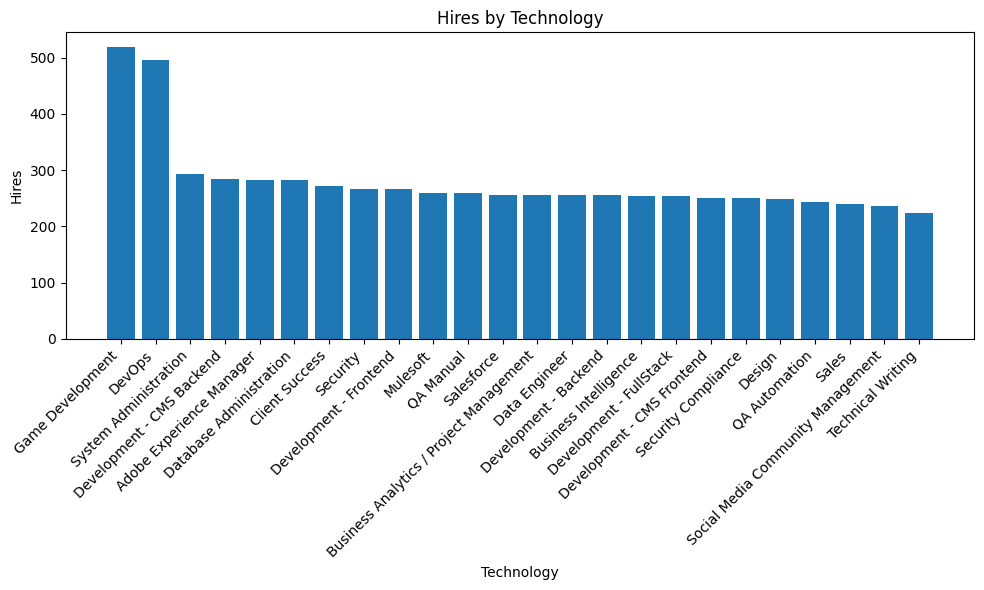

In [17]:
# 1) SQL
sql = """
SELECT t.technology_name AS Technology,
       COUNT(*)          AS Hires
FROM FactApplication f
JOIN DimTechnology t ON f.technology_key = t.technology_key
WHERE f.hired_flag = 1
GROUP BY t.technology_name
ORDER BY Hires DESC;
"""

# 2) Ejecutar y traer datos
cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_tech = pd.DataFrame(rows, columns=cols)

# 3) Graficar
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(kpi_tech["Technology"], kpi_tech["Hires"])
ax.set_title("Hires by Technology")
ax.set_xlabel("Technology")
ax.set_ylabel("Hires")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

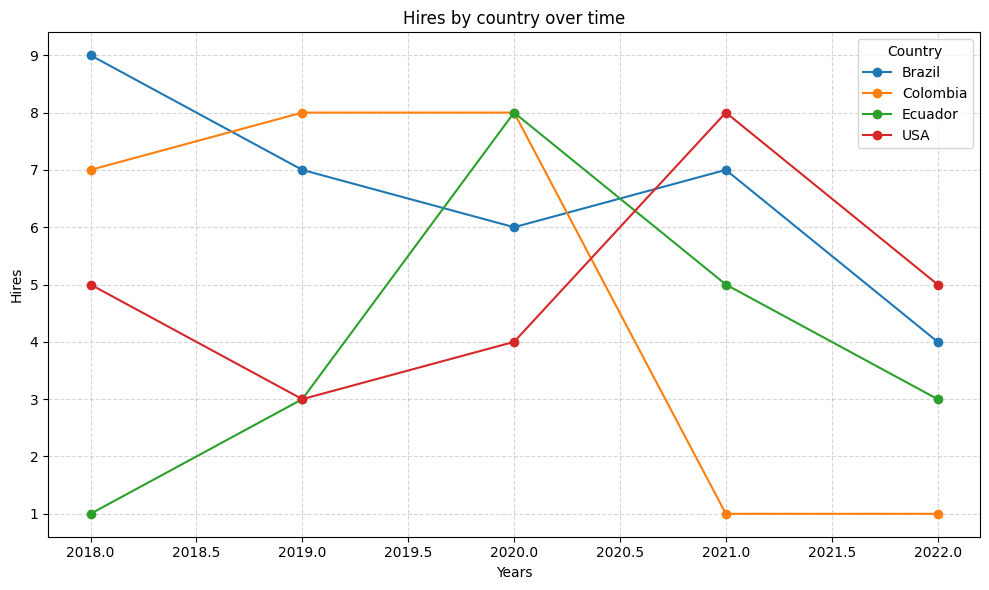

In [18]:


# 1) SQL (normaliza USA)
sql = """
SELECT d.year AS Year,
       CASE
         WHEN c.country_name IN ('United States of America','USA') THEN 'USA'
         ELSE c.country_name
       END AS Country,
       COUNT(*) AS Hires
FROM FactApplication f
JOIN DimDate d    ON f.date_key = d.date_key
JOIN DimCountry c ON f.country_key = c.country_key
WHERE f.hired_flag = 1
  AND c.country_name IN ('United States of America','USA','Brazil','Colombia','Ecuador')
GROUP BY d.year, Country
ORDER BY d.year, Country;
"""

# 2) Ejecutar y traer datos
cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
df_country_year = pd.DataFrame(rows, columns=cols)

# 3) Pivot para líneas múltiples
pivot = df_country_year.pivot(index="Year", columns="Country", values="Hires").fillna(0)

# 4) Graficar
fig, ax = plt.subplots(figsize=(10,6))
pivot.plot(ax=ax, marker="o")
ax.set_title("Hires by country over time")
ax.set_xlabel("Years")
ax.set_ylabel("Hires")
ax.legend(title="Country", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()



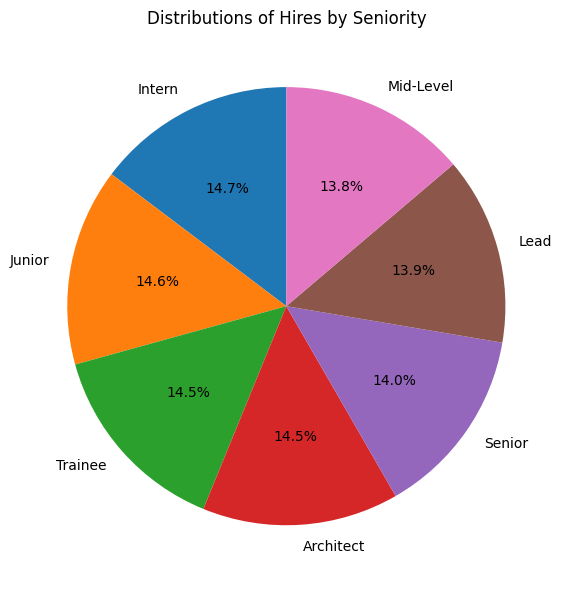

In [19]:

# 1) SQL
sql = """
SELECT s.seniority_level AS Seniority,
       COUNT(*)          AS Hires
FROM FactApplication f
JOIN DimSeniority s ON f.seniority_key = s.seniority_key
WHERE f.hired_flag = 1
GROUP BY s.seniority_level
ORDER BY Hires DESC;
"""

# 2) Ejecutar y traer datos
cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_seniority = pd.DataFrame(rows, columns=cols)

# 3) Graficar
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(kpi_seniority["Hires"], labels=kpi_seniority["Seniority"], autopct="%1.1f%%", startangle=90)
ax.set_title("Distributions of Hires by Seniority")
plt.tight_layout()



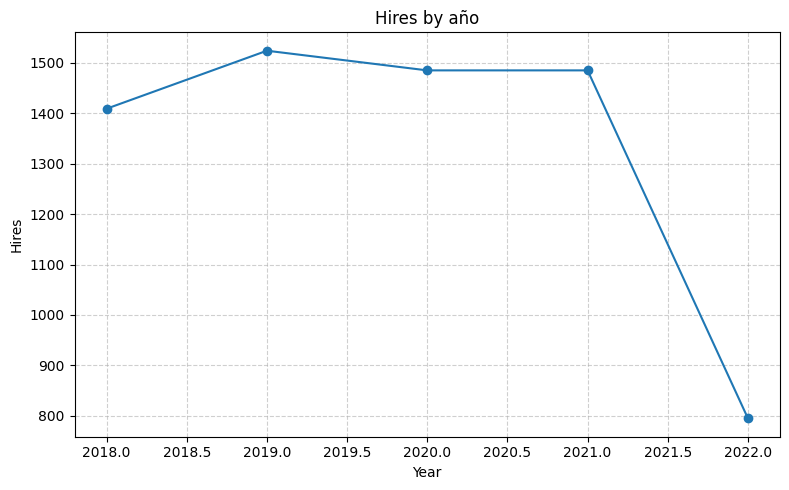

In [20]:
import os, pandas as pd, matplotlib.pyplot as plt

# 1) SQL
sql = """
SELECT d.year AS Year,
       COUNT(*) AS Hires
FROM FactApplication f
JOIN DimDate d ON f.date_key = d.date_key
WHERE f.hired_flag = 1
GROUP BY d.year
ORDER BY d.year;
"""

# 2) Ejecutar y traer datos
cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
kpi_year = pd.DataFrame(rows, columns=cols)

# 3) Graficar
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(kpi_year["Year"], kpi_year["Hires"], marker="o")
ax.set_title("Hires by año")
ax.set_xlabel("Year")
ax.set_ylabel("Hires")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()




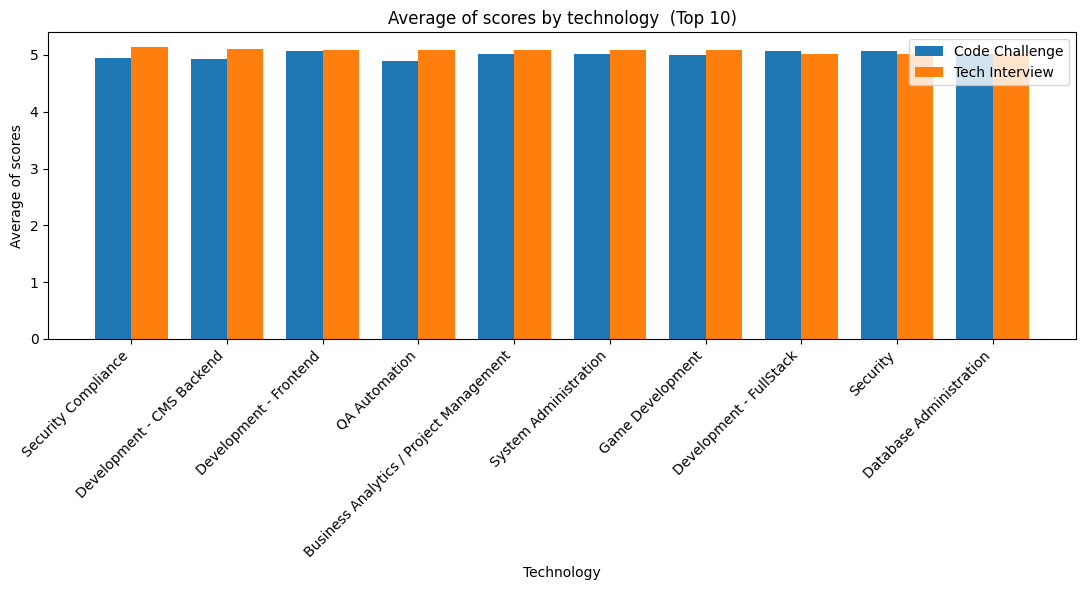

In [21]:


# 1) SQL: promedios por tecnología
sql = """
SELECT 
  t.technology_name AS Technology,
  ROUND(AVG(f.code_challenge_score), 2)      AS Avg_Code_Challenge,
  ROUND(AVG(f.technical_interview_score), 2) AS Avg_Tech_Interview
FROM FactApplication f
JOIN DimTechnology t ON f.technology_key = t.technology_key
GROUP BY t.technology_name
ORDER BY Avg_Tech_Interview DESC, Avg_Code_Challenge DESC;
"""

# 2) Ejecutar y traer datos
cursor.execute(sql)
rows = cursor.fetchall()
cols = [d[0] for d in cursor.description]
df_avg = pd.DataFrame(rows, columns=cols)

# (opcional) Reducir a top 10 tecnologías para un gráfico más limpio
topN = 10
df_plot = df_avg.head(topN).copy()

# 3) Preparar datos para barras agrupadas
x = np.arange(len(df_plot))  # posiciones
width = 0.38                 # ancho de cada barra

# 4) Graficar
fig, ax = plt.subplots(figsize=(11,6))
ax.bar(x - width/2, df_plot["Avg_Code_Challenge"], width, label="Code Challenge")
ax.bar(x + width/2, df_plot["Avg_Tech_Interview"], width, label="Tech Interview")

ax.set_title("Average of scores by technology  (Top 10)")
ax.set_xlabel("Technology")
ax.set_ylabel("Average of scores")
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Technology"], rotation=45, ha="right")
ax.legend()
plt.tight_layout()


